# Load Data

In [66]:
import pandas as pd
import names
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import random
from pyqubo import Constraint, Array
import neal
from dwave.system import LeapHybridSampler
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.rcParams["figure.figsize"] = (25,8)

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams.update({'font.size': 22})

In [67]:
l20 = pd.read_csv('League_df_2020.csv')
l21 = pd.read_csv('League_df_2021.csv')
t20 = pd.read_csv('Tournament_df_2020.csv')
t21 = pd.read_csv('Tournament_df_2021.csv')

sal_21 = pd.read_excel('2022-student-research-case-study-player-data.xlsx', "2021 Salaries")[11:].dropna(axis=1)
sal_21.columns = ['Player', 'Leagues', 'Squads', 'Nations', 'Positions', 'Salary']

sal_21.Player = sal_21.Player.str.replace('.', '').str.replace(' ','').str.replace('?','')
sal_21 = sal_21.drop(['Squads', 'Positions', 'Leagues'], axis=1)

sal_20 = pd.read_excel('2022-student-research-case-study-player-data.xlsx', "2020 Salaries")[11:].dropna(axis=1)
sal_20.columns = ['Player', 'Leagues', 'Squads', 'Nations', 'Positions', 'Salary']

sal_20.Player = sal_20.Player.str.replace('.', '').str.replace(' ','').str.replace('?','')
sal_20 = sal_20.drop(['Squads', 'Positions', 'Leagues'], axis=1)

In [68]:
def fix_data_league(alice1):
    
    alice1[["Age", "Born", "Year.x"]] = alice1[["Age", "Born", "Year.x"]].astype(str) 

    alice1['Nations'] = alice1['Nations'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Positions'] = alice1['Positions'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Leagues'] = alice1['Leagues'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Squads'] = alice1['Squads'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Age'] = alice1['Age'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Born'] = alice1['Born'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Year.x'] = alice1['Year.x'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Year'] = alice1['Year.x']
    
    alice1 = alice1.drop(['Year.x', 'Year.y'], axis=1)
    
    return alice1

def fix_data_tourn(alice1):
    alice1[["Age", "Born", "Year"]] = alice1[["Age", "Born", "Year"]].astype(str) 

    alice1['Nations'] = alice1['Nations'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Positions'] = alice1['Positions'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Leagues'] = alice1['Leagues'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Age'] = alice1['Age'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Born'] = alice1['Born'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)
    alice1['Year'] = alice1['Year'].apply(lambda x: x.split(',')[1] if str.__contains__(x, ',') else x)


    return alice1

l20 = fix_data_league(l20)
l21 = fix_data_league(l21)
t20 = fix_data_tourn(t20)
t21 = fix_data_tourn(t21)

league2 = sal_21.sort_values('Player').drop_duplicates('Player', keep = 'last').merge(l21)
tourn2 = t21.merge(sal_21, on = ['Player', "Nations"], how='left')
league1 = sal_20.sort_values('Player').drop_duplicates('Player', keep = 'last').merge(l20)
tourn1 = t20.merge(sal_20, on = ['Player', "Nations"], how='left')

tourn1.Salary = tourn1.Salary.fillna(0)
tourn2.Salary = tourn2.Salary.fillna(0)

In [69]:
##correlation plot##

# p1 = league2[['Playing Time MP_Goalkeeping',
#        'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
#        'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
#        'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
#        'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
#        'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
#        'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
#        'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
#        'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
#        'Penalty Kicks Save%_Goalkeeping']].corr().abs()

# matrix = np.triu(p1)
# sns.heatmap(p1, 
#             xticklabels=p1.columns.values,
#             yticklabels=p1.columns.values, annot=True, mask=matrix)
# plt.show()

In [70]:
# def adjust_stats_by_league(league2):
    
#     gb1 = league2.groupby('Player').max()
#     gb2 = league2.groupby('Player').min()

#     df_roster = pd.DataFrame()

#     for i in league2.Positions.unique():

#         gb1_i = gb1.loc[i]
#         gb2_i = gb2.loc[i]
#         league2_i = league2[league2.Positions == i]

#         num_cols = ['90s_Shooting', 'Gls_Shooting', 'Standard Sh_Shooting',
#            'Standard SoT_Shooting', 'Standard SoT%_Shooting',
#            'Standard Sh/90_Shooting', 'Standard SoT/90_Shooting',
#            'Standard G/Sh_Shooting', 'Standard G/SoT_Shooting',
#            'Standard Dist_Shooting', 'Standard FK_Shooting',
#            'Performance PK_Shooting', 'Performance PKatt_Shooting',
#            'Expected xG_Shooting', 'Expected npxG_Shooting',
#            'Expected npxG/Sh_Shooting', 'Expected G-xG_Shooting',
#            'Expected np:G-xG_Shooting', '90s_Passing', 'Total Cmp_Passing',
#            'Total Att_Passing', 'Total Cmp%_Passing', 'Total TotDist_Passing',
#            'Total PrgDist_Passing', 'Short Cmp_Passing', 'Short Att_Passing',
#            'Short Cmp%_Passing', 'Medium Cmp_Passing', 'Medium Att_Passing',
#            'Medium Cmp%_Passing', 'Long Cmp_Passing', 'Long Att_Passing',
#            'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing', 'A-xA_Passing',
#            'KP_Passing', '1/3_Passing', 'PPA_Passing', 'CrsPA_Passing',
#            'Prog_Passing', '90s_Defense', 'Tackles Tkl_Defense',
#            'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
#            'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
#            'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
#            'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
#            'Pressures Press_Defense', 'Pressures Succ_Defense',
#            'Pressures %_Defense', 'Pressures Def 3rd_Defense',
#            'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
#            'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
#            'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
#            'Err_Defense', 'Playing Time MP_Goalkeeping',
#            'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
#            'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
#            'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
#            'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
#            'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
#            'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
#            'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
#            'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
#            'Penalty Kicks Save%_Goalkeeping']

#         for j in num_cols:

#             league2_i[j] = (league2_i[j] - gb2_i[j])/(gb1_i[j] - gb2_i[j])

#         df_roster = pd.concat([df_roster,league2_i])

#     return df_roster

# league2 = adjust_stats_by_league(league2)
# league1 = adjust_stats_by_league(league1)

# Get Player Ratings

In [71]:
# def get_player_ratings(df):
    
# #     df['shot_accuracy'] = np.mean(df[['90s_Shooting','Standard SoT_Shooting', 'Standard SoT%_Shooting',
# #        'Standard Sh/90_Shooting', 'Standard SoT/90_Shooting']].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['finishing'] = np.mean(df[['90s_Shooting','Gls_Shooting',
# #       'Standard G/Sh_Shooting', 'Standard G/SoT_Shooting']].rank(pct=True,numeric_only=True), axis=1)*100
    
    
# #     df['shot_power'] = np.mean(df[['90s_Shooting','Standard Dist_Shooting', 'Standard Sh_Shooting']].rank(pct=True,numeric_only=True), axis=1)*100

# #     df['dangerous_rate'] = np.mean(df[['90s_Shooting','Expected xG_Shooting', 'Expected npxG_Shooting',
# #        'Expected npxG/Sh_Shooting', 'Expected G-xG_Shooting',
# #        'Expected np:G-xG_Shooting']].rank(pct=True,numeric_only=True), axis=1)*100
    
#     df['overall_fwd'] = np.mean(df[['90s_Shooting', 'Gls_Shooting',
#        'Standard Sh_Shooting', 'Standard SoT_Shooting',
#        'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
#        'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
#        'Standard G/SoT_Shooting', 'Standard Dist_Shooting',
#        'Standard FK_Shooting', 'Performance PK_Shooting',
#        'Performance PKatt_Shooting', 'Expected xG_Shooting',
#        'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
#        'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting' ]].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['long_pass'] = np.mean(df[['90s_Passing','Long Cmp_Passing', 'Long Att_Passing',
# #        'Long Cmp%_Passing', 'CrsPA_Passing', 'Total TotDist_Passing',
# #        'Total PrgDist_Passing', 'Prog_Passing']].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['short_pass'] = np.mean(df[['90s_Passing','Total Cmp_Passing',
# #        'Total Att_Passing', 'Total Cmp%_Passing', 'Short Cmp_Passing', 'Short Att_Passing',
# #        'Short Cmp%_Passing', 'Medium Cmp_Passing', 'Medium Att_Passing',
# #        'Medium Cmp%_Passing' ]].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['playmaking'] = np.mean(df[['90s_Passing','Ast_Passing', 'xA_Passing', 'A-xA_Passing',
# #        'KP_Passing', '1/3_Passing', 'PPA_Passing']].rank(pct=True,numeric_only=True), axis=1)*100
    
#     df['overall_mid'] = np.mean(df[['90s_Passing',
#        'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
#        'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
#        'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
#        'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
#        'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing',
#        'A-xA_Passing', 'KP_Passing', '1/3_Passing', 'PPA_Passing',
#        'CrsPA_Passing', 'Prog_Passing']].rank(pct=True,numeric_only=True), axis=1)*100

    
# #     df['error_rate'] = np.mean(df[['90s_Defense','Vs Dribbles Past_Defense', 'Err_Defense' ]].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['good_error_rate'] = 100 - df['error_rate']
    
# #     df['tackling'] = np.mean(df[['90s_Defense','Tackles Tkl_Defense',
# #        'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
# #        'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
# #        'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
# #        'Vs Dribbles Tkl%_Defense',
# #        'Pressures Press_Defense', 'Pressures Succ_Defense',
# #        'Pressures %_Defense', 'Pressures Def 3rd_Defense',
# #        'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense']].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df['awwareness'] = np.mean(df[['90s_Defense','Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
# #        'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense']].rank(pct=True,numeric_only=True), axis=1)*100
    
    
#     df['overall_def'] = np.mean(df[['90s_Defense', 'Tackles Tkl_Defense',
#        'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
#        'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
#        'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
#        'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
#        'Pressures Press_Defense', 'Pressures Succ_Defense',
#        'Pressures %_Defense', 'Pressures Def 3rd_Defense',
#        'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
#        'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
#        'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
#        'Err_Defense']].rank(pct=True,numeric_only=True), axis=1)*100
    
    
#     df['gk'] = np.mean(df[['Playing Time MP_Goalkeeping',
#        'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
#        'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
#        'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
#        'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
#        'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
#        'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
#        'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
#        'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
#        'Penalty Kicks Save%_Goalkeeping']].rank(pct=True,numeric_only=True), axis=1)*100
    
# #     df = df.drop(['90s_Shooting', 'Gls_Shooting', 'Standard Sh_Shooting',
# #        'Standard SoT_Shooting', 'Standard SoT%_Shooting',
# #        'Standard Sh/90_Shooting', 'Standard SoT/90_Shooting',
# #        'Standard G/Sh_Shooting', 'Standard G/SoT_Shooting',
# #        'Standard Dist_Shooting', 'Performance PK_Shooting',
# #        'Performance PKatt_Shooting', 'Standard FK_Shooting',
# #        'Expected xG_Shooting', 'Expected npxG_Shooting',
# #        'Expected npxG/Sh_Shooting', 'Expected G-xG_Shooting',
# #        'Expected np:G-xG_Shooting', '90s_Passing', 'Total Cmp_Passing',
# #        'Total Att_Passing', 'Total Cmp%_Passing', 'Total TotDist_Passing',
# #        'Total PrgDist_Passing', 'Short Cmp_Passing', 'Short Att_Passing',
# #        'Short Cmp%_Passing', 'Medium Cmp_Passing', 'Medium Att_Passing',
# #        'Medium Cmp%_Passing', 'Long Cmp_Passing', 'Long Att_Passing',
# #        'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing', 'A-xA_Passing',
# #        'KP_Passing', '1/3_Passing', 'PPA_Passing', 'CrsPA_Passing',
# #        'Prog_Passing', '90s_Defense', 'Tackles Tkl_Defense',
# #        'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
# #        'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
# #        'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
# #        'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
# #        'Pressures Press_Defense', 'Pressures Succ_Defense',
# #        'Pressures %_Defense', 'Pressures Def 3rd_Defense',
# #        'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
# #        'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
# #        'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
# #        'Err_Defense', 'Playing Time MP_Goalkeeping',
# #        'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
# #        'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
# #        'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
# #        'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
# #        'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
# #        'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
# #        'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
# #        'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
# #        'Penalty Kicks Save%_Goalkeeping', 'Unnamed: 0', 'Born'], axis=1)
    
#     return df
    
# tourn1 = get_player_ratings(tourn1)
# league1 = get_player_ratings(league1)
# tourn2 = get_player_ratings(tourn2)
# league2 = get_player_ratings(league2)

league = pd.concat([league1, league2], axis=0)
tourn = pd.concat([tourn1, tourn2], axis=0)

league = pd.concat([league, tourn], axis=0).drop_duplicates(['Player', 'Year'], keep = 'first')

# Get Best Position

In [72]:
# def get_pos(df):
    
#     fwds = ['FW', 'FWMF', 'FWDF', 'MFFW', 'DFFW']
#     mids = [ 'MF', 'MFFW', 'GKMF', 'MFGK', 'MFDF', 'DFMF']
#     d = ['DF', 'DFFW', 'DFMF', 'MFDF', 'FWDF']
#     gk = ['GK', 'GKMF',  'MFGK']
    
#     df.loc[(df.overall_fwd >= df.overall_mid) & (df.overall_fwd >= df.overall_def), "Pos"] = "F"
#     df.loc[(df.overall_mid >= df.overall_fwd) & (df.overall_mid >= df.overall_def), "Pos"] = "M"
#     df.loc[(df.overall_def >= df.overall_mid) & (df.overall_def >= df.overall_fwd), "Pos"] = "D"
#     df.loc[(df.Positions.isin(gk)) & (df.gk >= df.overall_mid) & (df.gk >= df.overall_def) & (df.gk >= df.overall_fwd), "Pos"] = "G"
#     league.Squads = league.Squads.fillna('Tournament')
#     league.Leagues = league.Leagues.fillna('Tournament')
#     return df
    
    
# #tourn = get_pos(tourn)
# league = get_pos(league) 
# league.gk = league.gk.fillna(0)

# def get_ovr(league):
#     league.loc[league.Pos == 'M', 'Ovr'] = 0.7*league.loc[league.Pos == 'M']['overall_mid'] + 0.3*league.loc[league.Pos == 'M']['overall_fwd']
#     league.loc[league.Pos == 'F', 'Ovr'] = 0.8*league.loc[league.Pos == 'F']['overall_fwd'] + 0.2*league.loc[league.Pos == 'F']['overall_mid']
#     league.loc[league.Pos == 'D', 'Ovr'] = 0.8*league.loc[league.Pos == 'D']['overall_def'] + 0.2*league.loc[league.Pos == 'D']['overall_mid']
#     league.loc[league.Pos == 'G', 'Ovr'] = league.loc[league.Pos == 'G']['gk']
#     league.Squads = league.Squads.fillna('Tournament')
#     league.Leagues = league.Leagues.fillna('Tournament')
#     return league

# league = get_ovr(league)

In [73]:
league.Year = league.Year.astype(str)

In [74]:
league.columns

Index(['Player', 'Nations', 'Salary', 'Unnamed: 0', 'Squads', 'Positions',
       'Leagues', 'Age', 'Born', '90s_Shooting', 'Gls_Shooting',
       'Standard Sh_Shooting', 'Standard SoT_Shooting',
       'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
       'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
       'Standard G/SoT_Shooting', 'Standard Dist_Shooting',
       'Standard FK_Shooting', 'Performance PK_Shooting',
       'Performance PKatt_Shooting', 'Expected xG_Shooting',
       'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
       'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting', '90s_Passing',
       'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
       'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
       'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
       'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
       'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passi

In [75]:
le = preprocessing.LabelEncoder()

data = league[league['Year'] == '2020']

le.fit(data['Nations'])
data['Nations_cat'] = le.transform(data['Nations'])


le.fit(data['Squads'])
data['Squads_cat'] = le.transform(data['Squads'])


le.fit(data['Leagues'])
data['Leagues_cat'] = le.transform(data['Leagues'])

le.fit(data['Positions'])
data['Positions_cat'] = le.transform(data['Positions'])

data = data[['Nations_cat', 'Squads_cat', 'Positions_cat', 'Age', 'Leagues_cat', 'Salary','90s_Shooting','W_Goalkeeping','Err_Defense', 'churn' ]]


X = data[['Nations_cat', 'Squads_cat', 'Positions_cat', 'Age', 'Leagues_cat', 'Salary','90s_Shooting','W_Goalkeeping','Err_Defense']].values
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("Model Score")
print(clf.score(X_train, y_train))

Model Score
0.7568339453284374


In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       675
           1       0.86      0.56      0.68       533

    accuracy                           0.77      1208
   macro avg       0.80      0.75      0.75      1208
weighted avg       0.79      0.77      0.76      1208



In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test))

array([[628,  47],
       [233, 300]])

In [87]:
feats

[-8.050833000227777e-06,
 -1.5824573432197942e-05,
 -8.434766980341156e-07,
 -4.0859033474289744e-06,
 -1.00514978917378e-06,
 1.0,
 2.288148453645318e-06,
 1.503826704154281e-09,
 -2.0657156696981694e-09]

In [89]:
feats = []

for i in [4.28083598e-13,8.41433468e-13,  4.48498360e-14,  2.17258041e-13,
   5.34464121e-14, -5.31725845e-08, -1.21666767e-13, -7.99623525e-17,
   1.09839441e-16]:
    
    feats.append((i - np.mean([4.28083598e-13,8.41433468e-13,  4.48498360e-14,  2.17258041e-13,
   5.34464121e-14, -5.31725845e-08, -1.21666767e-13, -7.99623525e-17,
   1.09839441e-16]))/np.std([4.28083598e-13,8.41433468e-13,  4.48498360e-14,  2.17258041e-13,
   5.34464121e-14, -5.31725845e-08, -1.21666767e-13, -7.99623525e-17,
   1.09839441e-16]))

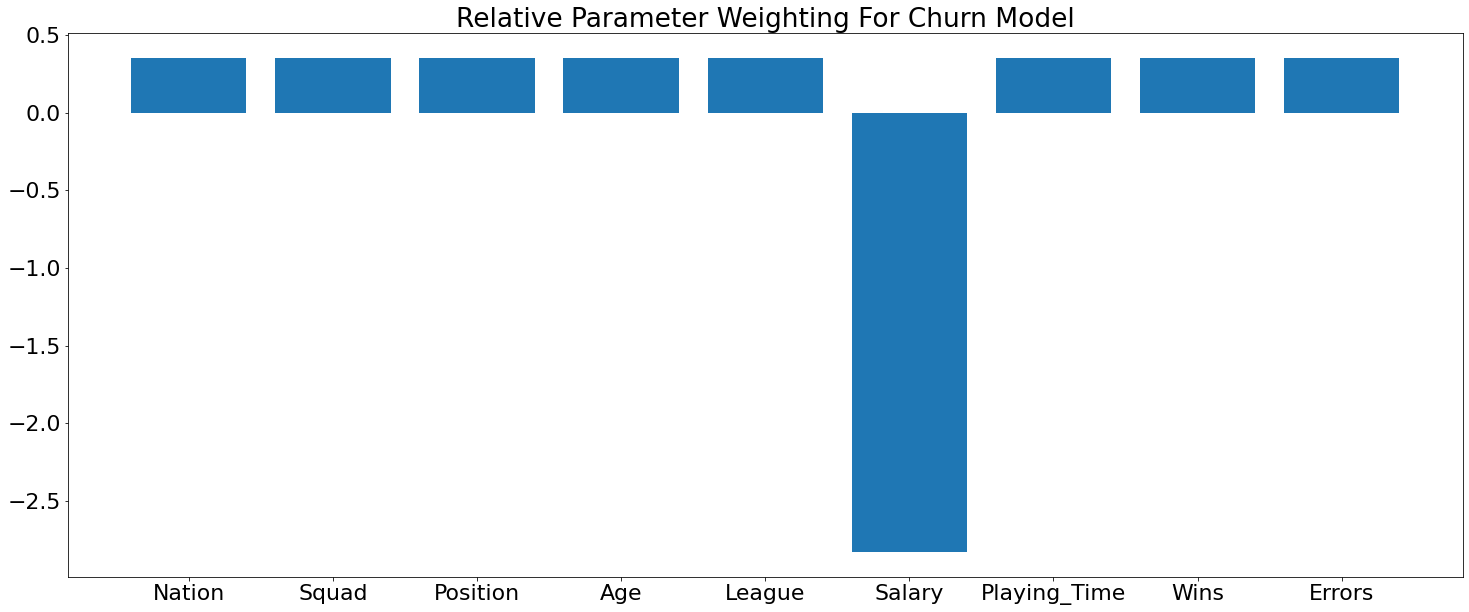

In [96]:
plt.bar(["Nation", "Squad", "Position", "Age", "League", "Salary", "Playing_Time", "Wins", "Errors"], 
        feats)
plt.title('Relative Parameter Weighting For Churn Model')
plt.show()

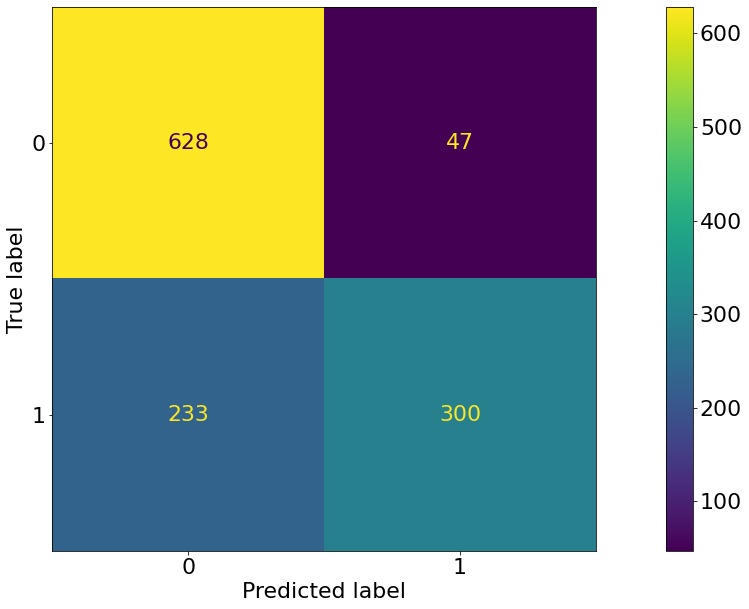

In [103]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

# League Churn Model (Log. Regress)

In [10]:
def player_churn_model(league, year):
    le = preprocessing.LabelEncoder()

    data = league[league['Year'] == '2020']

    le.fit(data['Nations'])
    data['Nations_cat'] = le.transform(data['Nations'])


    le.fit(data['Squads'])
    data['Squads_cat'] = le.transform(data['Squads'])


    le.fit(data['Leagues'])
    data['Leagues_cat'] = le.transform(data['Leagues'])

    le.fit(data['Positions'])
    data['Positions_cat'] = le.transform(data['Positions'])

    data = data[['Nations_cat', 'Squads_cat', 'Positions_cat', 'Age', 'Leagues_cat', 'Salary','90s_Shooting','W_Goalkeeping','Err_Defense', 'churn' ]]


    X = data[['Nations_cat', 'Squads_cat', 'Positions_cat', 'Age', 'Leagues_cat', 'Salary','90s_Shooting','W_Goalkeeping','Err_Defense']].values
    y = data['churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)

    print("Model Score")
    print(clf.score(X_train, y_train))

    league_year = league[league['Year'] == year]

    league_year_data = league_year.reset_index(drop=True)

    le.fit(league_year_data['Nations'])
    league_year_data['Nations_cat'] = le.transform(league_year_data['Nations'])


    le.fit(league_year_data['Squads'])
    league_year_data['Squads_cat'] = le.transform(league_year_data['Squads'])


    le.fit(league_year_data['Leagues'])
    league_year_data['Leagues_cat'] = le.transform(league_year_data['Leagues'])

    le.fit(league_year_data['Positions'])
    league_year_data['Positions_cat'] = le.transform(league_year_data['Positions'])

    league_year_data_x = league_year_data[['Nations_cat', 'Squads_cat', 'Positions_cat', 'Age', 'Leagues_cat', 'Salary','90s_Shooting','W_Goalkeeping','Err_Defense' ]]

    preds = pd.DataFrame(clf.predict_proba(league_year_data_x)).reset_index(drop=True)
    preds.columns = ['Active', "Churn"]

    df_with_preds = pd.concat([league_year_data,preds], axis=1)

    kicked_players = df_with_preds[df_with_preds.Churn > 0.5]

    print("Number of Players Kicked")
    num_kicked = len(kicked_players)
    print(num_kicked)

    remaining_players = df_with_preds[df_with_preds.Churn <= 0.7]
    remaining_players = remaining_players.drop(['Nations_cat',
       'Squads_cat', 'Positions_cat', 'Active', 'Churn'], axis=1)
    
    league = league[league.Year != year]
    
    remaining_players = pd.concat([remaining_players, league], axis=0)

    return num_kicked, kicked_players, remaining_players


num_kicked, kicked_players, league_22 = player_churn_model(league, '2021')
league_22 = league_22.drop_duplicates(['Player', 'Year'])

Model Score
0.7568339453284374
Number of Players Kicked
195


# Age & Advance Player Overalls

In [11]:
def advance_year(year, league):
    league = league[league.Year == year]    
    
    player = pd.DataFrame()

    player["Player"] = league.Player.tolist()
    player["Nations"] = league.Nations.tolist()
    player["Squads"] = league.Squads.tolist()
    player["Age"] = league.Age.astype(int).tolist()
    #player["Positions"] = league.Positions.tolist()
    player["Positions"] = league.Positions.tolist()
    player['Year'] = league.Year.astype(int).tolist()
    player['Salary'] = league.Salary.astype(int).tolist()

    num_cols = ['90s_Shooting', 'Gls_Shooting',
       'Standard Sh_Shooting', 'Standard SoT_Shooting',
       'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
       'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
       'Standard G/SoT_Shooting', 'Standard Dist_Shooting',
       'Standard FK_Shooting', 'Performance PK_Shooting',
       'Performance PKatt_Shooting', 'Expected xG_Shooting',
       'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
       'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting', '90s_Passing',
       'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
       'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
       'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
       'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
       'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing',
       'A-xA_Passing', 'KP_Passing', '1/3_Passing', 'PPA_Passing',
       'CrsPA_Passing', 'Prog_Passing', '90s_Defense', 'Tackles Tkl_Defense',
       'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
       'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
       'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
       'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
       'Pressures Press_Defense', 'Pressures Succ_Defense',
       'Pressures %_Defense', 'Pressures Def 3rd_Defense',
       'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
       'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
       'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
       'Err_Defense', 'Playing Time MP_Goalkeeping',
       'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
       'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
       'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
       'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
       'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
       'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
       'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
       'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
       'Penalty Kicks Save%_Goalkeeping']

    for i in num_cols:

        player[i] = league[i].tolist() 
        
    player['Year'] = player['Year'] + 1
    player['Age'] = player['Age'] + 1
    player['Salary'] = player['Salary']*1.02 + np.random.binomial(1, 0.15)*player['Salary']*1.1

    return player

def get_next_year(year, league):
    
    teams1 = league[league.Leagues == 'A'].Squads.to_list()
    teams2 =league[league.Leagues == 'B'].Squads.to_list()
    teams3 =league[league.Leagues == 'C'].Squads.to_list()
    teams4 =league[league.Leagues == 'D'].Squads.to_list()
    teams5 =league[league.Leagues == 'E'].Squads.to_list()
    teams6 =league[league.Leagues == 'RFL'].Squads.to_list()

    temp_df = advance_year(year, league)

    num_cols = ['90s_Shooting', 'Gls_Shooting',
       'Standard Sh_Shooting', 'Standard SoT_Shooting',
       'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
       'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
       'Standard G/SoT_Shooting', 'Standard Dist_Shooting',
       'Standard FK_Shooting', 'Performance PK_Shooting',
       'Performance PKatt_Shooting', 'Expected xG_Shooting',
       'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
       'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting', '90s_Passing',
       'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
       'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
       'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
       'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
       'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing',
       'A-xA_Passing', 'KP_Passing', '1/3_Passing', 'PPA_Passing',
       'CrsPA_Passing', 'Prog_Passing', '90s_Defense', 'Tackles Tkl_Defense',
       'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
       'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
       'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
       'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
       'Pressures Press_Defense', 'Pressures Succ_Defense',
       'Pressures %_Defense', 'Pressures Def 3rd_Defense',
       'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
       'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
       'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
       'Err_Defense', 'Playing Time MP_Goalkeeping',
       'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
       'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
       'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
       'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
       'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
       'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
       'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
       'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
       'Penalty Kicks Save%_Goalkeeping']
    
    
    fwds = ['MFFW', 'DFFW', 'FW','MFFW']
    mids = ['FWMF','MF','GKMF','DFMF', ]
    d = ['DF', 'MFDF', 'FWDF', ]
    gk = ['GK',  'MFGK']
    
    x = temp_df.Positions.isin(d)
    y = temp_df.Positions.isin(gk)
    
    z = temp_df.Positions.isin(fwds)
    t = temp_df.Positions.isin(mids)

    for i in num_cols:

        temp_df.loc[((x)|(y))&(temp_df.Age <= 24), i] = temp_df.loc[((x)|(y))&(temp_df.Age <= 24), i]*1.08
        temp_df.loc[((x)|(y))&(temp_df.Age <= 28)&(temp_df.Age > 24), i] = temp_df.loc[((x)|(y))&(temp_df.Age <= 28)&(temp_df.Age > 24), i] 
        temp_df.loc[((x)|(y))&(temp_df.Age >= 28), i] = temp_df.loc[((x)|(y))&(temp_df.Age >= 28), i]*0.92

        temp_df.loc[((z)|(t))&(temp_df.Age <= 26), i] = temp_df.loc[((z)|(t))&(temp_df.Age <= 26), i]*1.05
        temp_df.loc[((z)|(t))&(temp_df.Age <= 30)&(temp_df.Age > 26), i] = temp_df.loc[((z)|(t))&(temp_df.Age <= 30)&(temp_df.Age > 26), i] 
        temp_df.loc[((z)|(t))&(temp_df.Age >= 30), i] = temp_df.loc[((z)|(t))&(temp_df.Age >= 30), i]*0.95
    
    temp_df["Leagues"] = np.nan
    temp_df.loc[temp_df.Squads.isin(teams1), "Leagues"] = 'A'
    temp_df.loc[temp_df.Squads.isin(teams2), "Leagues"] = 'B'
    temp_df.loc[temp_df.Squads.isin(teams3), "Leagues"] = 'C'
    temp_df.loc[temp_df.Squads.isin(teams4), "Leagues"] = 'D'
    temp_df.loc[temp_df.Squads.isin(teams5), "Leagues"] = 'E'
    temp_df.loc[temp_df.Squads.isin(teams6), "Leagues"] = 'RFL'
        
    return temp_df

league_22 = get_next_year("2021", league_22)
league_22.Leagues = league_22.Leagues.fillna('Tournament')
league = pd.concat([league, league_22], axis=0)
league.churn = league.churn.fillna(0)

# Generate Players

In [12]:
def get_new_player(year, kicked_players, league_22):
    used_names = kicked_players.Player.to_list()
    
    name = names.get_full_name(gender='male').replace(' ', '')

    if name in used_names:

        pass

    else:

        player = {}
        player["Player"] = name
        player["Nations"] = random.choice(kicked_players.Nations.tolist())
        player["Squads"] = random.choice(kicked_players.Squads.tolist())
        player["Age"] = round(np.random.uniform(17, 25))
        player["Positions"] = random.choice(kicked_players.Positions.tolist())
        player['Year'] = year
        player['Salary'] = round(np.random.normal(np.mean(league_22['Salary']), np.std(league_22['Salary'])))
        
        num_cols = ['90s_Shooting', 'Gls_Shooting',
       'Standard Sh_Shooting', 'Standard SoT_Shooting',
       'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
       'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
       'Standard G/SoT_Shooting', 'Standard Dist_Shooting',
       'Standard FK_Shooting', 'Performance PK_Shooting',
       'Performance PKatt_Shooting', 'Expected xG_Shooting',
       'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
       'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting', '90s_Passing',
       'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
       'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
       'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
       'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
       'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing', 'xA_Passing',
       'A-xA_Passing', 'KP_Passing', '1/3_Passing', 'PPA_Passing',
       'CrsPA_Passing', 'Prog_Passing', '90s_Defense', 'Tackles Tkl_Defense',
       'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
       'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
       'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
       'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
       'Pressures Press_Defense', 'Pressures Succ_Defense',
       'Pressures %_Defense', 'Pressures Def 3rd_Defense',
       'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
       'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
       'Blocks Pass_Defense', 'Int_Defense', 'Tkl+Int_Defense', 'Clr_Defense',
       'Err_Defense', 'Playing Time MP_Goalkeeping',
       'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
       'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
       'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
       'Performance Saves_Goalkeeping', 'Performance Save%_Goalkeeping',
       'W_Goalkeeping', 'D_Goalkeeping', 'L_Goalkeeping',
       'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
       'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
       'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
       'Penalty Kicks Save%_Goalkeeping']
        
        try:
        
            for i in num_cols:

                player[i] = np.random.normal(np.mean(league_22[i]), np.std(league_22[i]))
                
        except:
            
            print('An Error Occured')

        return player

def add_players_to_league(num_kicked, year, kicked_players, league_22):
    
    player_dict = {}
    
    for i in range(num_kicked):
        
        player_dict[i] = get_new_player(year, kicked_players, league_22)
                    
    return player_dict

new_players = pd.DataFrame(add_players_to_league(num_kicked, '2022', kicked_players, league)).T
#new_players = get_player_ratings(new_players)
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
# new_league_22= new_league_22.drop_duplicates(['Player', 'Year'], keep = 'last')

# teams1 = league[league.Leagues == 'A'].Squads.to_list()
# teams2 =league[league.Leagues == 'B'].Squads.to_list()
# teams3 =league[league.Leagues == 'C'].Squads.to_list()
# teams4 =league[league.Leagues == 'D'].Squads.to_list()
# teams5 =league[league.Leagues == 'E'].Squads.to_list()
# teams6 =league[league.Leagues == 'RFL'].Squads.to_list()

# new_league_22.loc[new_league_22.Squads.isin(teams1), "Leagues"] = 'A'
# new_league_22.loc[new_league_22.Squads.isin(teams2), "Leagues"] = 'B'
# new_league_22.loc[new_league_22.Squads.isin(teams3), "Leagues"] = 'C'
# new_league_22.loc[new_league_22.Squads.isin(teams4), "Leagues"] = 'D'
# new_league_22.loc[new_league_22.Squads.isin(teams5), "Leagues"] = 'E'
# new_league_22.loc[new_league_22.Squads.isin(teams6), "Leagues"] = 'RFL'

In [13]:
####generate 10 years of data##
####randomly add +1 to rarita players each year from funding##
###multiply all non-rarita salaries by 10%, rarita salaries by -10%

In [14]:
league.Year = league.Year.astype(str)
league = league.drop(['Born', 'Unnamed: 0'], axis=1)

In [15]:
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

# 2023

In [16]:

num_kicked, kicked_players, league_23 = player_churn_model(league, '2022')
league_23 = league_23.drop_duplicates(['Player', 'Year'])

Model Score
0.7568339453284374
Number of Players Kicked
209


In [17]:
league_23 = get_next_year("2022", league_23)
league_23.Leagues = league_23.Leagues.fillna('Tournament')
league = pd.concat([league, league_23], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league_23.Year = league_23.Year.astype(str)

In [18]:
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2023', kicked_players, league_23)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)

In [19]:
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

# 2024

In [20]:
num_kicked, kicked_players, league_24 = player_churn_model(league, '2023')
league_24 = league_24.drop_duplicates(['Player', 'Year'])


league_24 = get_next_year("2023", league_24)
league_24.Leagues = league_24.Leagues.fillna('Tournament')
league = pd.concat([league, league_24], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2024', kicked_players, league_24)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
216


# 2025

In [21]:
num_kicked, kicked_players, league_25 = player_churn_model(league, '2024')
league_25 = league_25.drop_duplicates(['Player', 'Year'])


league_25 = get_next_year("2024", league_25)
league_25.Leagues = league_25.Leagues.fillna('Tournament')
league = pd.concat([league, league_25], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2025', kicked_players, league_25)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
225


# 2026

In [22]:
num_kicked, kicked_players, league_26 = player_churn_model(league, '2025')
league_26 = league_26.drop_duplicates(['Player', 'Year'])


league_26 = get_next_year("2025", league_26)
league_26.Leagues = league_26.Leagues.fillna('Tournament')
league = pd.concat([league, league_26], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2026', kicked_players, league_26)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
234


# 2027

In [23]:
num_kicked, kicked_players, league_27 = player_churn_model(league, '2026')
league_27 = league_27.drop_duplicates(['Player', 'Year'])


league_27 = get_next_year("2026", league_27)
league_27.Leagues = league_27.Leagues.fillna('Tournament')
league = pd.concat([league, league_27], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2027', kicked_players, league_27)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
244


# 2028

In [24]:
num_kicked, kicked_players, league_28 = player_churn_model(league, '2027')
league_28 = league_28.drop_duplicates(['Player', 'Year'])


league_28 = get_next_year("2027", league_28)
league_28.Leagues = league_28.Leagues.fillna('Tournament')
league = pd.concat([league, league_28], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2028', kicked_players, league_28)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
253


# 2029

In [25]:
num_kicked, kicked_players, league_29 = player_churn_model(league, '2028')
league_29 = league_29.drop_duplicates(['Player', 'Year'])


league_29 = get_next_year("2028", league_29)
league_29.Leagues = league_29.Leagues.fillna('Tournament')
league = pd.concat([league, league_29], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2029', kicked_players, league_29)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
263


# 2030

In [26]:
num_kicked, kicked_players, league_30 = player_churn_model(league, '2029')
league_30 = league_30.drop_duplicates(['Player', 'Year'])


league_30 = get_next_year("2028", league_30)
league_30.Leagues = league_30.Leagues.fillna('Tournament')
league = pd.concat([league, league_30], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2030', kicked_players, league_30)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
254


# 2031

In [27]:
num_kicked, kicked_players, league_31 = player_churn_model(league, '2030')
league_31 = league_31.drop_duplicates(['Player', 'Year'])


league_31 = get_next_year("2029", league_31)
league_31.Leagues = league_31.Leagues.fillna('Tournament')
league = pd.concat([league, league_31], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2031', kicked_players, league_31)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
12


In [28]:
num_kicked, kicked_players, league_32 = player_churn_model(league, '2031')
league_32 = league_32.drop_duplicates(['Player', 'Year'])


league_32 = get_next_year("2030", league_32)
league_32.Leagues = league_32.Leagues.fillna('Tournament')
league = pd.concat([league, league_32], axis=0)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
new_players = pd.DataFrame(add_players_to_league(num_kicked, '2032', kicked_players, league_32)).T
#new_players = get_pos(new_players)
league = pd.concat([league, new_players], axis=0)
#league = get_ovr(league)
league.churn = league.churn.fillna(0)
league.Year = league.Year.astype(str)
league[['Leagues', 'Squads']]=league[['Leagues', 'Squads']].fillna('Tournament')

Model Score
0.7568339453284374
Number of Players Kicked
2


In [29]:
league['Efficiency'] = ((1/(1 + league['90s_Shooting'] + league['90s_Passing'] + league['90s_Defense'] + league['Playing Time 90s_Goalkeeping']))*(league['Gls_Shooting'] - 
                                                       league['Err_Defense'] + league['xA_Passing'] 
                                                           + league['W_Goalkeeping']))

In [30]:
league = league.drop([ 
       'Standard Sh_Shooting',
       'Standard SoT%_Shooting', 'Standard Sh/90_Shooting',
       'Standard SoT/90_Shooting', 'Standard G/Sh_Shooting',
       'Standard FK_Shooting', 'Performance PK_Shooting',
       'Performance PKatt_Shooting', 'Expected xG_Shooting',
       'Expected npxG_Shooting', 'Expected npxG/Sh_Shooting',
       'Expected G-xG_Shooting', 'Expected np:G-xG_Shooting', '90s_Passing',
       'Total Cmp_Passing', 'Total Att_Passing', 'Total Cmp%_Passing',
       'Total TotDist_Passing', 'Total PrgDist_Passing', 'Short Cmp_Passing',
       'Short Att_Passing', 'Short Cmp%_Passing', 'Medium Cmp_Passing',
       'Medium Att_Passing', 'Medium Cmp%_Passing', 'Long Cmp_Passing',
       'Long Att_Passing', 'Long Cmp%_Passing', 'Ast_Passing',
       'A-xA_Passing', 'KP_Passing', 'PPA_Passing',
       'CrsPA_Passing', '90s_Defense', 'Tackles Tkl_Defense',
       'Tackles TklW_Defense', 'Tackles Def 3rd_Defense',
       'Tackles Mid 3rd_Defense', 'Tackles Att 3rd_Defense',
       'Vs Dribbles Tkl_Defense', 'Vs Dribbles Att_Defense',
       'Vs Dribbles Tkl%_Defense', 'Vs Dribbles Past_Defense',
       'Pressures Press_Defense', 'Pressures Succ_Defense',
       'Pressures %_Defense', 'Pressures Def 3rd_Defense',
       'Pressures Mid 3rd_Defense', 'Pressures Att 3rd_Defense',
       'Blocks Blocks_Defense', 'Blocks Sh_Defense', 'Blocks ShSv_Defense',
       'Blocks Pass_Defense', 'Int_Defense', 'Playing Time MP_Goalkeeping',
       'Playing Time Starts_Goalkeeping', 'Playing Time Min_Goalkeeping',
       'Playing Time 90s_Goalkeeping', 'Performance GA_Goalkeeping',
       'Performance GA90_Goalkeeping', 'Performance SoTA_Goalkeeping',
       'Performance Saves_Goalkeeping',
        'L_Goalkeeping',
       'Performance CS_Goalkeeping', 'Performance CS%_Goalkeeping',
       'Performance PKatt_Goalkeeping', 'Penalty Kicks PKA_Goalkeeping',
       'Penalty Kicks PKsv_Goalkeeping', 'Penalty Kicks PKm_Goalkeeping',
       'Penalty Kicks Save%_Goalkeeping'], axis = 1)

In [31]:
league.columns = ['Player', 'Nations', 'Salary', 'Squads', 'Positions', 'Leagues', 'Age',
       'time', 'goals', 'sot', 'gps',
       'dist', 'xa', 'cross','pass',
       'def', 'err', 'd1', 'sv',
       'w', 'd', 'churn', 'Year', 'eff']


In [32]:
league.Year = league.Year.astype(str)
league.goals = league.goals.astype(float)

In [33]:
league.eff = league.eff.astype(float)

# Linear Mixed Effects Model

In [ ]:
#league = league[league.Positions != '0']

In [35]:
league = league.dropna(axis=0)

In [36]:
mod = smf.mixedlm("eff ~ Leagues + Year + Positions", league, groups=league["Player"])
mdf = mod.fit()
print(mdf.summary())
mdf.params

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    eff      
No. Observations:    51630      Method:                REML     
No. Groups:          6553       Scale:                 0.0385   
Min. group size:     1          Log-Likelihood:        6613.1033
Max. group size:     13         Converged:             Yes      
Mean group size:     7.9                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.010    0.036  0.278 0.781 -0.060  0.080
Leagues[T.B]           0.006    0.008  0.709 0.478 -0.011  0.023
Leagues[T.C]           0.007    0.009  0.847 0.397 -0.010  0.024
Leagues[T.D]           0.016    0.009  1.875 0.061 -0.001  0.033
Leagues[T.E]           0.005    0.008  0.629 0.529 -0.011  0.022
Leagues[T.RFL]         0.009    0.010  

Intercept                0.009960
Leagues[T.B]             0.005981
Leagues[T.C]             0.007385
Leagues[T.D]             0.016169
Leagues[T.E]             0.005290
Leagues[T.RFL]           0.008949
Leagues[T.Tournament]    0.012664
Year[T.2021]            -0.006394
Year[T.2022]            -0.006460
Year[T.2023]            -0.006506
Year[T.2024]            -0.004430
Year[T.2025]            -0.003971
Year[T.2026]            -0.002075
Year[T.2027]            -0.014500
Year[T.2028]            -0.007429
Year[T.2029]            -0.006932
Year[T.2030]            -0.007294
Year[T.2031]            -0.007340
Year[T.2032]            -0.013616
Positions[T.DF]         -0.009454
Positions[T.DFFW]        0.004241
Positions[T.DFMF]       -0.004265
Positions[T.FW]          0.020191
Positions[T.FWDF]        0.003845
Positions[T.FWMF]        0.011219
Positions[T.GK]         -0.001097
Positions[T.GKMF]       -0.030327
Positions[T.MF]          0.004201
Positions[T.MFDF]        0.000332
Positions[T.MF

In [38]:
params = {
    "A":0,
    "B":-0.006394,
    "C":0.007385,
    "D":0.016564,
    "E":0.005290,
    "RFL":0.008949,
    "Tournament":0.012664,
    "2020":0,
    "2021":-0.006394,
    "2022":-0.006460,
    "2023":-0.006506,
    "2024":-0.004430,
    "2025": -0.003971,
    "2026":-0.002075,
    "2027":-0.014500,
    "2028": -0.007429,
    "2029":-0.006932,
    "2030": -0.007340,
    "2031":-0.013616,
    "2032":-0.013616,
    "0":0,
    "DF":-0.009454,
    "DFFW":0.004241,
    "DFMF": -0.004265,
    "FW":0.020191,
    "FWDF":0.003845,
    "FWMF":0.011219,
    "GK":-0.001097,
    "GKMF":-0.030327,
    "MF":0.004201,
    "MFDF":0.000332,
    'MFFW':0.009182
}


def get_adjusted_ovr(eff, year, league, pos, params):

    new_ovr =  0.026699 + eff*params[year] + eff*params[league] + eff*params[pos]
    
    return new_ovr



league['adjust_ovr'] = (league.apply(lambda x:get_adjusted_ovr(x['eff'], x['Year'], 
                                x['Leagues'],x['Positions'],params), axis=1))



In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

print(scaler.fit(league.adjust_ovr.values.reshape(-1, 1)))

league['test'] = scaler.transform(league.adjust_ovr.values.reshape(-1, 1))

MinMaxScaler()


In [ ]:
(league['test'] - np.mean(league['test']))/np.std(league['test'])

In [43]:
league['test'] = 100*league['test']

In [51]:
len(league)

51630

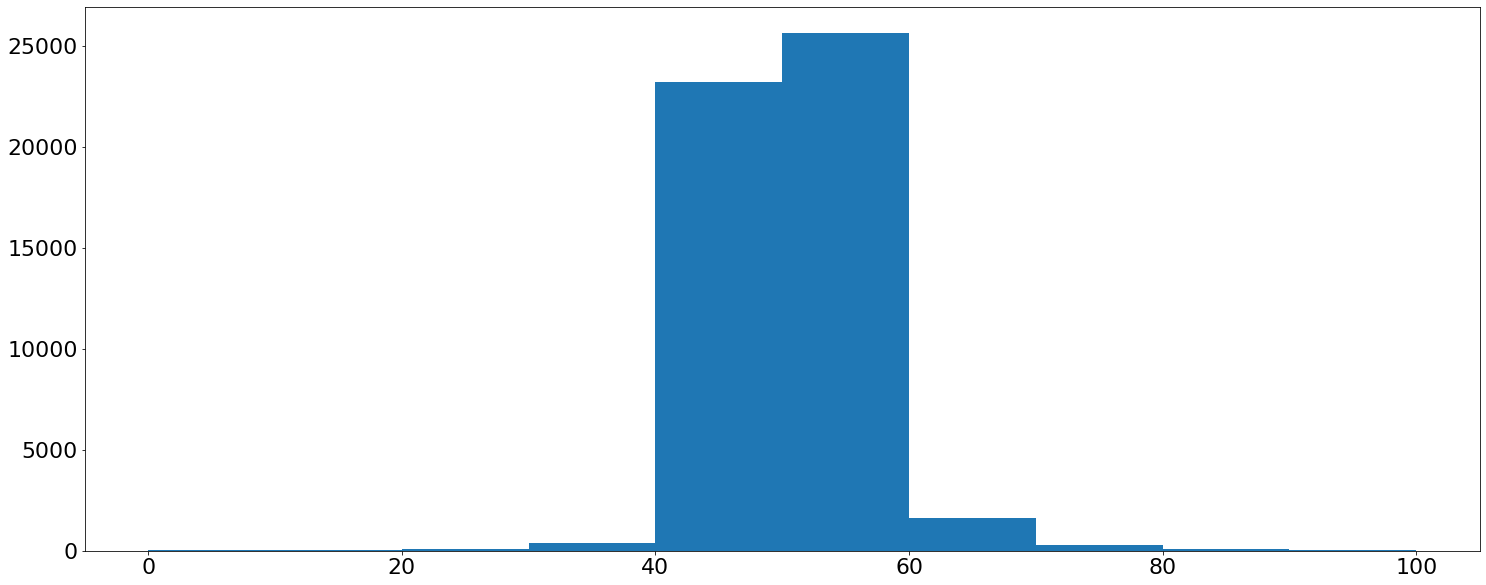

In [60]:
plt.hist(league_test2['adjust_ovr'])
plt.show()

In [56]:
league_test = league[(league.adjust_ovr > (np.mean(league['adjust_ovr']) - 3*np.std(league['adjust_ovr'])))&
      
      (league.adjust_ovr < (np.mean(league['adjust_ovr']) + 3*np.std(league['adjust_ovr'])))]

# Adjust Overall Ratings

In [58]:
def normalize(league, year):
    league = league[league.Year == year]
    #league['adjust_ovr'] = league['adjust_ovr'].fillna(league['Ovr'])
    league['adjust_ovr'] = abs(league['adjust_ovr'] - min(league['adjust_ovr']))/(max(league['adjust_ovr']) - min(league['adjust_ovr']))
    league['adjust_ovr'] = league['adjust_ovr']*100
    return league

l1 = normalize(league_test, "2020")
l2 = normalize(league_test, "2021")
l3 = normalize(league_test, "2022")
l4 = normalize(league_test, "2023")
l5 = normalize(league_test, "2024")
l6 = normalize(league_test, "2025")
l7 = normalize(league_test, "2026")
l8 = normalize(league_test, "2027")
l9 = normalize(league_test, "2028")
l10 = normalize(league_test, "2029")
l11 = normalize(league_test, "2030")
l12 = normalize(league_test, "2031")
l13 = normalize(league_test, "2032")

league_test2 = pd.concat([l1,l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13], axis=0)



In [61]:
league_test2.to_csv("soa_2020_2030.csv")

# Build Team for Each Nation

In [62]:
def get_trim_roster(df_roster, team):
    
    gk = ['GK', 'GKMF',  'MFGK']

    test = df_roster[df_roster.Nations == team].drop_duplicates('Player', keep='last')
    
#     test.loc[test.Pos == 'M', 'Ovr'] = test['adjust_ovr']
#     test.loc[test.Pos == 'F', 'Ovr'] = test['adjust_ovr']
#     test.loc[test.Pos == 'D', 'Ovr'] = test['adjust_ovr']
#     test.loc[test.Pos == 'G', 'Ovr'] = test['adjust_ovr']
    
    gks = test[test.Positions.isin(gk)].sort_values('adjust_ovr', ascending = False).head(2)
    
    test = test.sort_values('adjust_ovr', ascending = False).head(22)
    
    test = pd.concat([test, gks], axis=0)
    
    if (len(test) < 18)|(len(gks) < 1):
        pass
    
    
    #testfull = testfull.drop(['player_name_x', 'player_name_y','player_id', 'team_id', 'game_id' ], axis=1)
    else:
        return test

df_roster = pd.DataFrame()

for i in league_test2.Nations.unique():
    df_team = get_trim_roster(league_test2[league_test2.Year == '2021'], i)
    df_roster = pd.concat([df_roster,df_team])

In [63]:
team_ratings = df_roster.groupby('Nations')['adjust_ovr'].mean().reset_index()

team_ratings.sort_values(by = 'adjust_ovr', ascending=False).head(24)


,Nations,adjust_ovr
29,Sobianitedrucy,63.153043
20,Nganion,57.752785
5,Dosqaly,55.148829
26,Rarita,55.134366
8,Esia,54.614661
22,Nkasland Cronestan,54.447375
2,Byasier Pujan,53.644579
12,Imaar Vircoand,53.530835
17,Manlisgamncent,53.473892
11,Greri Landmoslands,51.791025


In [64]:
df_roster[df_roster.Nations == 'Rarita']['Salary'].sum()

189170000

In [ ]:
league['adjust_ovr'].hist()
plt.show()

In [ ]:
plt.hist(100*league[league.Year == '2023']['adjust_ovr']/max(league[league.Year == '2023']['adjust_ovr']))
plt.show()